<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> ⬇️Imports⬇️</center>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Conv1D, GlobalAveragePooling1D, Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

2024-04-29 11:33:38.535836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 11:33:38.535970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 11:33:38.677479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
column_names = ['index','Description','Label']
df = pd.read_excel("/kaggle/input/cyber-bullying/CyberBulling Dataset Bangla.xlsx", names=column_names)
df.head()

,index,Description,Label
0,1202,সে ভোট ডাকাত সরকারের এজেন্ট,Threat
1,1203,"জুতা দিয়ে তোমার গালে মারা উচিত, আবাল বক্তব্য দ...",Threat
2,1204,তোরে জুতা পিডা দিয়া হোয়াইট হাউসের বুয়া বানাই দ...,Threat
3,1205,"যেভাবে চারদিকে দূর্ণীতি ও লুটপাট শুরু হয়েছে, ত...",Threat
4,1206,আবালে তাকায় কেম্নে মনে হয় খাইয়ালব্ব,Threat


In [3]:
# Drop the 'index' column
df.drop('index', axis=1, inplace=True)
df.head()

,Description,Label
0,সে ভোট ডাকাত সরকারের এজেন্ট,Threat
1,"জুতা দিয়ে তোমার গালে মারা উচিত, আবাল বক্তব্য দ...",Threat
2,তোরে জুতা পিডা দিয়া হোয়াইট হাউসের বুয়া বানাই দ...,Threat
3,"যেভাবে চারদিকে দূর্ণীতি ও লুটপাট শুরু হয়েছে, ত...",Threat
4,আবালে তাকায় কেম্নে মনে হয় খাইয়ালব্ব,Threat


In [4]:
df['Label'] = df['Label'].replace('troll', 'Troll')

In [5]:
df.shape

(4808, 2)

In [6]:
df.isnull().sum()

Description    0
Label          0
dtype: int64

In [7]:
df.Label.unique()

array(['Threat', 'Political', 'Troll', 'Neutral'], dtype=object)

In [8]:
# Drop the null values
df.dropna(inplace=True)

In [9]:
df['Label'].value_counts()

Label
Political    1205
Troll        1202
Neutral      1201
Threat       1200
Name: count, dtype: int64

In [10]:
df1=pd.read_csv("/kaggle/input/cyberbully-english/cyber.csv")

In [11]:
df1.head()

,Index,Description,Label
0,5.0,এখন বুঝলাম কেন তোদের কে জবাই করে.....,Threat
1,39.0,প্রধানমন্ত্রী হক সাহেবের ক্ষতি হলে জাতির স্বার...,Threat
2,126.0,"Anyways, now I wear overalls, practice yoga, a...",Threat
3,127.0,If u n school right now then fuck ya life wit ...,Threat
4,128.0,Apparently his followers think that’s what tou...,Threat


In [12]:
df1=df1.drop("Index", axis=1)

In [13]:
df1.isnull().sum()

Description    0
Label          0
dtype: int64

In [14]:
df1.Label.unique()

array(['Threat', 'Political', 'Neutral', 'Troll'], dtype=object)

In [15]:
# combined_df = pd.concat([df, df1], ignore_index=True)

In [16]:
# df=combined_df

# <a id="3"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> 🧐EDA🧐</center>


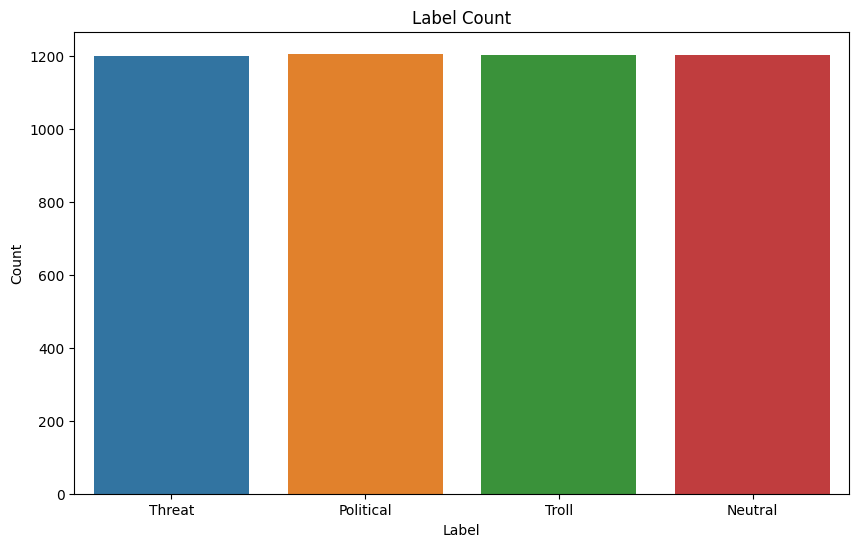

In [17]:
# plot  troll sexual Threat Neutral
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count')
plt.show()

In [18]:
df['sen_len'] = df['Description'].apply(lambda x: len(x.split()))

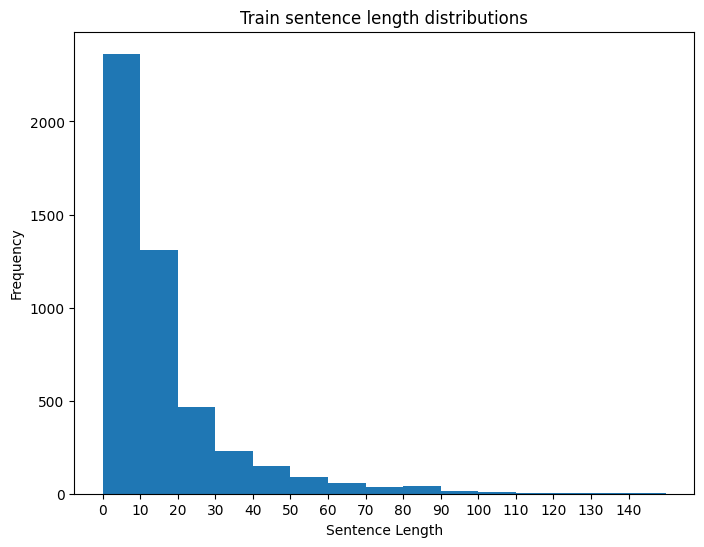

In [19]:
plt.figure(figsize=(8, 6))
df.sen_len.plot(kind='hist',bins=[i for i in range(0,151,10)])
plt.xticks(np.arange(0, 150, step=10))
plt.xlabel('Sentence Length')
plt.title('Train sentence length distributions')
plt.show()


### Observation: Most Sentences are 1-30 words long

In [20]:
df[df['sen_len']>100]

,Description,Label,sen_len
24,"আসিফের বাবা নিশ্চয় কুকুর প্রজাতির,কিংবা গরুর।ক...",Threat,166
46,"জেনে ভাল লাগল, আপনি সব ধর্মের কিতাব পড়েছেন, আপ...",Threat,172
68,পাঠ্য পুস্তক থেকে মুসলিম কবি/সাহিত্যিকদের কবিত...,Threat,101
78,প্রিয়া সাহা মহিলা ঐক্য পরিষদ’র কেন্দ্রীয় কমিটি...,Threat,149
82,"আমি নিজে ও নাস্তিক দের বিপক্ষে,আমার কাছে যেটা ...",Threat,170
119,নাস্তিকদের খুব কমন একটা প্রশ্ন হচ্ছে: যেটা দেখ...,Threat,155
142,সাফা না কাঁপা কে যেন তুই!?বাতাস কি দেখেছিস কখন...,Threat,159
145,আপু আপনি যে বিষয় নিয়ে আছেন সেটা সম্পন্ন হারাম।...,Threat,113
281,দেশের রাজনীতিতে গত ১৮ বছরে BNP এর সবচেয়ে বড় কা...,Threat,165
366,আপনি অভিনয় জগতের মানুষ। অভিনয় করতে গিয়ে অনেক স...,Threat,153


**Observation**
* There are some really large sentences

In [21]:
vocab = {}
for sen in tqdm(df.Description):
    for j in sen.split(" "):
        try:
            vocab[j]+=1
        except:
            vocab[j]=1
print("Total words in vocabulary : ",len(vocab))

sorted_vocab = sorted(vocab.items(),key = lambda kv:kv[1],reverse=True)
sorted_vocab[:20]

100%|██████████| 4808/4808 [00:00<00:00, 122172.83it/s]

Total words in vocabulary :  19307


[('না', 882),
 ('করে', 766),
 ('এই', 658),
 ('আর', 639),
 ('কি', 582),
 ('জুতা', 514),
 ('ও', 437),
 ('কে', 381),
 ('তো', 379),
 ('থেকে', 371),
 ('কথা', 337),
 ('জন্য', 328),
 ('তার', 318),
 ('যে', 318),
 ('করা', 306),
 ('এর', 298),
 ('একটা', 297),
 ('কোন', 293),
 ('আপনার', 291),
 ('বিশ্বাস', 281)]

In [22]:
chars = {}
for sen in tqdm(df.Description):
    for j in sen:
        try:
            chars[j]+=1
        except:
            chars[j]=1
chars

100%|██████████| 4808/4808 [00:00<00:00, 46896.21it/s]


{'স': 9249,
 'ে': 32523,
 ' ': 74163,
 'ভ': 2934,
 'ো': 6350,
 'ট': 4209,
 'ড': 1070,
 'া': 47895,
 'ক': 18985,
 'ত': 14702,
 'র': 28935,
 'এ': 4134,
 'জ': 5713,
 'ন': 20292,
 '্': 14291,
 'ু': 8516,
 'দ': 9208,
 'ি': 19193,
 'য়': 6343,
 'ম': 11697,
 'গ': 3734,
 'ল': 12719,
 'উ': 1312,
 'চ': 3603,
 ',': 2477,
 'আ': 6278,
 'ব': 13675,
 'য': 5262,
 'খ': 3098,
 'ঁ': 369,
 'ষ': 1748,
 '।': 3815,
 'থ': 2337,
 'শ': 4172,
 'ও': 2513,
 'প': 7112,
 'ছ': 4315,
 'হ': 5929,
 'ঙ': 319,
 'অ': 1669,
 'ই': 5908,
 '!': 761,
 'ূ': 336,
 'ণ': 499,
 'ী': 2455,
 'ং': 1377,
 'ধ': 1672,
 '?': 1030,
 'ড়': 835,
 'ৎ': 158,
 'ফ': 1396,
 '-': 323,
 '়': 902,
 'ঞ': 139,
 '১': 135,
 'ঠ': 531,
 'ৈ': 132,
 'ঘ': 371,
 'ৃ': 276,
 '\u200c': 131,
 'ঈ': 70,
 ')': 72,
 'ঝ': 329,
 '.': 1772,
 'D': 24,
 'W': 12,
 '/': 97,
 'R': 13,
 'e': 292,
 'u': 133,
 't': 218,
 'r': 168,
 's': 180,
 'C': 24,
 'N': 24,
 'B': 37,
 'E': 41,
 'x': 4,
 'i': 206,
 'n': 211,
 'c': 87,
 'S': 29,
 'd': 112,
 'y': 92,
 '৩': 44,
 '(': 59,
 'V': 4,


**Keypoints**
* There are lots of emojis and punctuations

<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> Visualization</center>


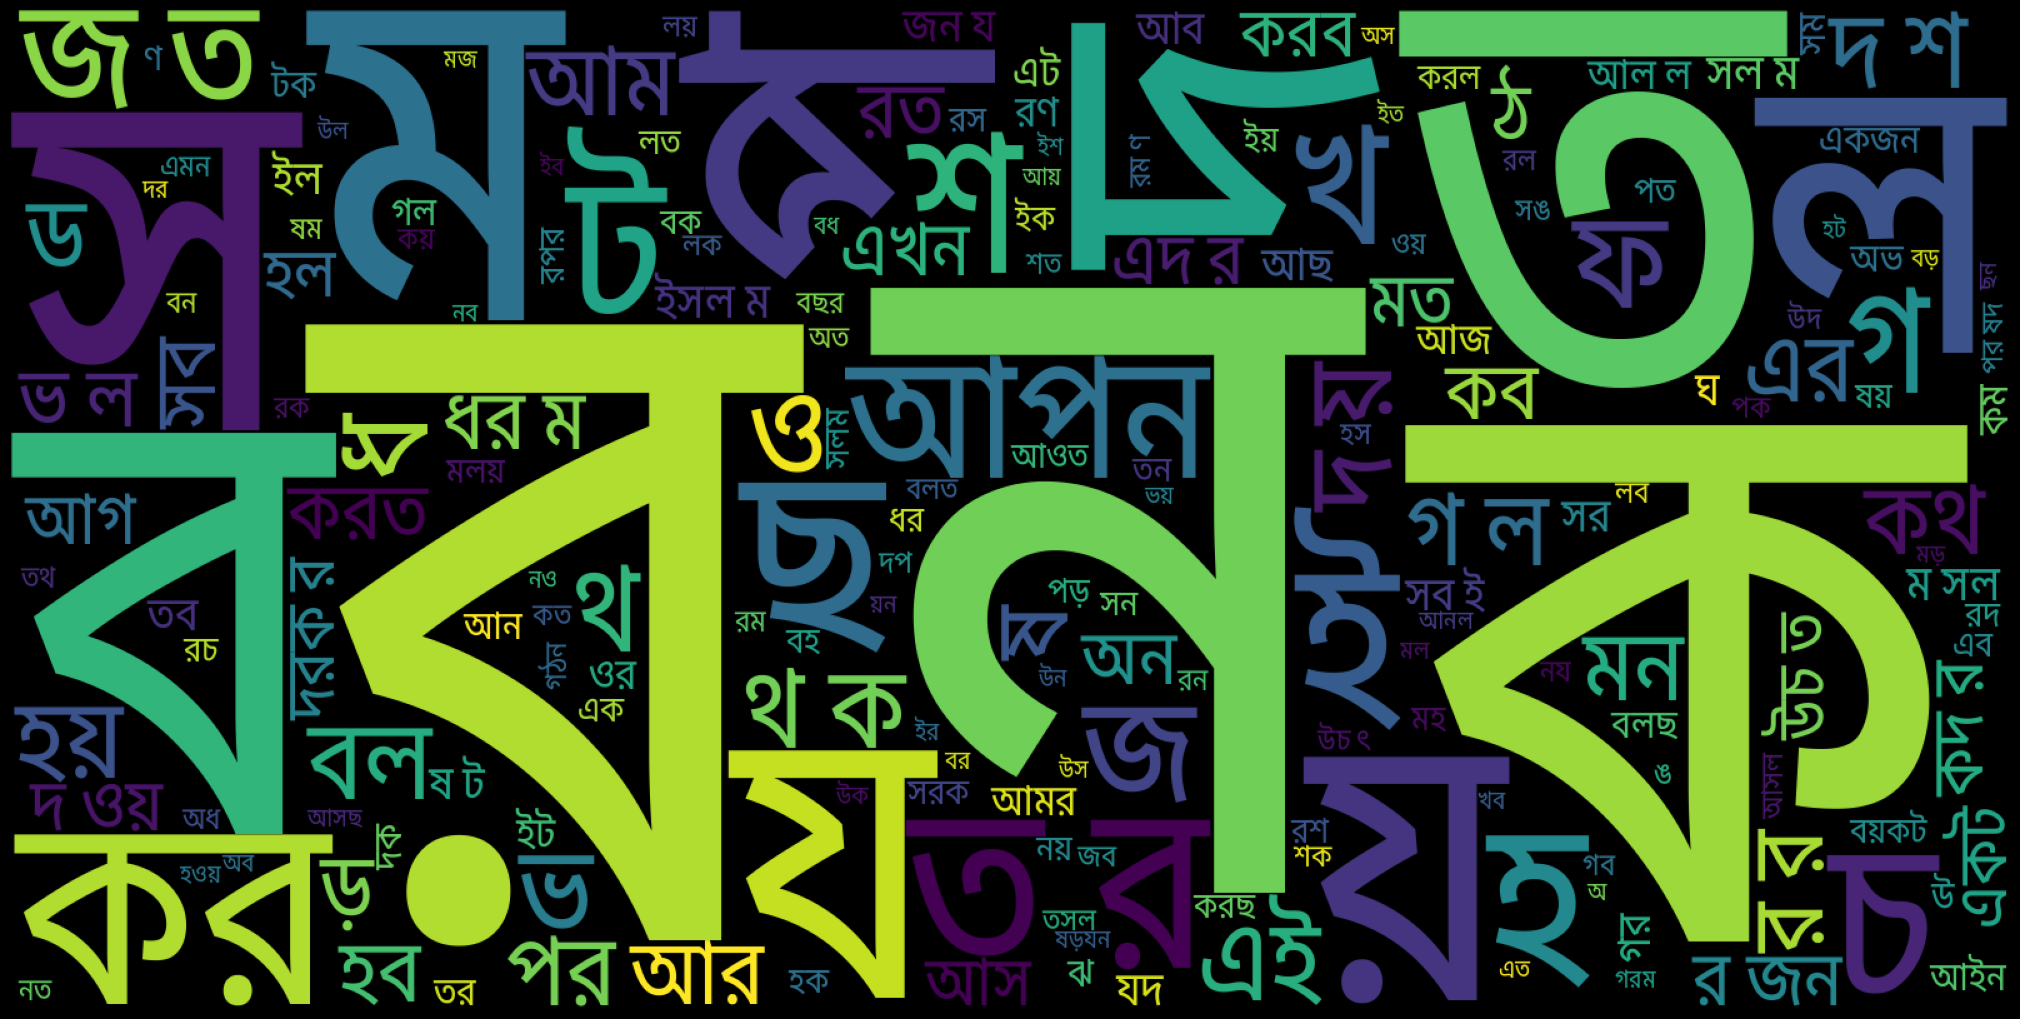

In [23]:
from wordcloud import WordCloud
def plot_world(text):

    wordcloud = WordCloud(width = 1600, height = 800, 
                    background_color ='black', 
                    font_path="/kaggle/input/notosansfont/NotoSansBengali_Condensed-Regular.ttf",
                    min_font_size = 10).generate(text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (20, 15), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
s= " ".join(df.Description[:100])
plot_world(s)

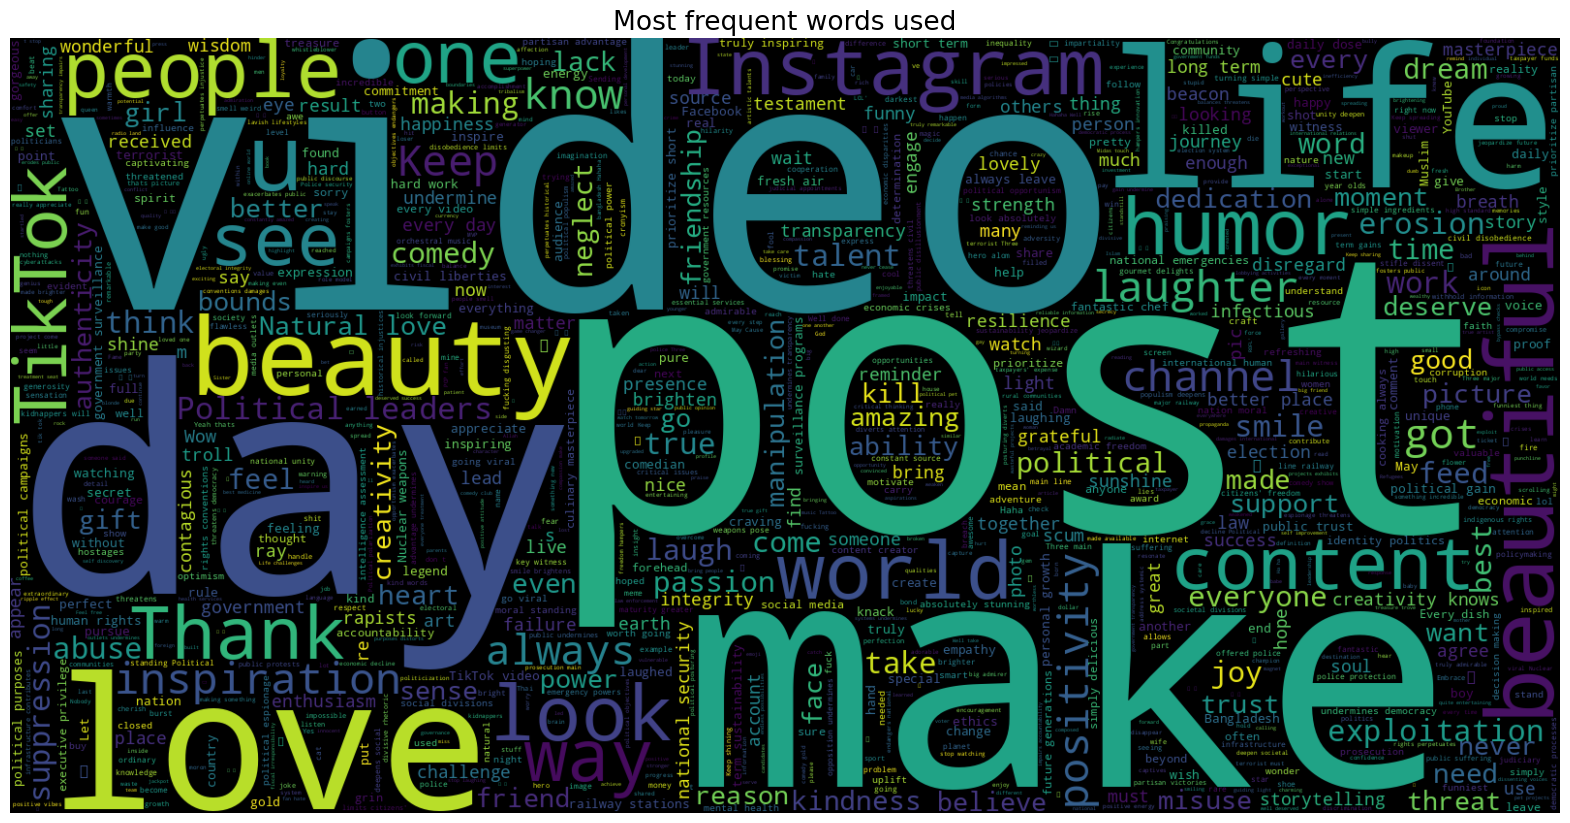

In [24]:
from wordcloud import WordCloud

text = ' '.join([word for word in df1['Description']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=1000, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words used', fontsize=19)
plt.show()

<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> Preprocessing</center>


In [25]:
# remove punctuations
punctuations = [
    "/::\)","/::","(-_-)","(*_*)","(>_<)",":)",";)",":P","xD","-_-","*_*","(>_<)","...",".",",",";",":","!","?","'","অ�", "অাবার", "।"
    "\"","-","_","/","\\","|","{","}","[","]","(",")","<",">","@","#","$","%","^","&","*","~","`","+","=","0","1","2","3","4","5","6","7","8","9","৳","০",
    "১","২","৩","৪","৫","৬","৭","৮","৯","\n","\t","\r","\f","\v","\u00C0-\u017F","\u2000-\u206F","\u25A0-\u25FF","\u2600-\u26FF","\u2B00-\u2BFF","\u3000-\u303F",
    "\uFB00-\uFB4F","\uFE00-\uFE0F","\uFE30-\uFE4F","\u1F600-\u1F64F","\u1F300-\u1F5FF","\u1F680-\u1F6FF","\u1F1E0-\u1F1FF","\u2600-\u26FF","\u2700-\u27BF",
    "\u1F300-\u1F5FF","\u1F900-\u1F9FF","\u1F600-\u1F64F","\u1F680-\u1F6FF","\u1F1E0-\u1F1FF","\u1F600-\u1F64F","।","\u200c","’","\"","∆","“","”",":","\u09e4","1","2","3","\u200d","…","৷","‘","2: ","ل","ك","ن","ر"
]

In [26]:
for i in range(len(df)):
    text = df.loc[i, "Description"]
    text = "".join(c for c in text if c not in punctuations)
    df.loc[i, "Description"] = text

In [27]:
def remove_arabic(text):
    arabic_pattern = re.compile(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]+')  # Pattern to match Arabic Unicode range
    return arabic_pattern.sub('', text)

# Apply the function to the 'text' column
df['Description'] = df['Description'].apply(remove_arabic)

In [28]:
chars = {}
for sen in tqdm(df.Description):
    for j in sen:
        try:
            chars[j]+=1
        except:
            chars[j]=1
chars


100%|██████████| 4808/4808 [00:00<00:00, 42316.03it/s]


{'স': 9249,
 'ে': 32523,
 ' ': 74163,
 'ভ': 2934,
 'ো': 6350,
 'ট': 4209,
 'ড': 1070,
 'া': 47895,
 'ক': 18985,
 'ত': 14702,
 'র': 28935,
 'এ': 4134,
 'জ': 5713,
 'ন': 20292,
 '্': 14291,
 'ু': 8516,
 'দ': 9208,
 'ি': 19193,
 'য়': 6343,
 'ম': 11697,
 'গ': 3734,
 'ল': 12719,
 'উ': 1312,
 'চ': 3603,
 'আ': 6278,
 'ব': 13675,
 'য': 5262,
 'খ': 3098,
 'ঁ': 369,
 'ষ': 1748,
 'থ': 2337,
 'শ': 4172,
 'ও': 2513,
 'প': 7112,
 'ছ': 4315,
 'হ': 5929,
 'ঙ': 319,
 'অ': 1669,
 'ই': 5908,
 'ূ': 336,
 'ণ': 499,
 'ী': 2455,
 'ং': 1377,
 'ধ': 1672,
 'ড়': 835,
 'ৎ': 158,
 'ফ': 1396,
 '়': 902,
 'ঞ': 139,
 'ঠ': 531,
 'ৈ': 132,
 'ঘ': 371,
 'ৃ': 276,
 'ঈ': 70,
 'ঝ': 329,
 'D': 24,
 'W': 12,
 'R': 13,
 'e': 292,
 'u': 133,
 't': 218,
 'r': 168,
 's': 180,
 'C': 24,
 'N': 24,
 'B': 37,
 'E': 41,
 'x': 4,
 'i': 206,
 'n': 211,
 'c': 87,
 'S': 29,
 'd': 112,
 'y': 92,
 'V': 4,
 'h': 165,
 'a': 329,
 'l': 142,
 'g': 69,
 'p': 75,
 'q': 7,
 'o': 293,
 'm': 85,
 'P': 35,
 'f': 65,
 'v': 34,
 'I': 9,
 'j': 14,
 'Y':

In [29]:
# remove emoji
import re

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

# identify data if remove_emoji function works
for i in range(len(df)):
    text = df.loc[i, "Description"]
    text = remove_emoji(text)
    df.loc[i, "Description"] = text

In [30]:
def remove_extra_space(text):
    text = re.sub(r"[a-zA-Z]+", "", text)
    return text

for i in range(len(df)):
    text = df.loc[i, "Description"]
    text = remove_extra_space(text)
    df.loc[i, "Description"] = text

In [31]:
# remove extra space
def remove_extra_space(text):
    text = re.sub(r"\s+", " ", text)
    return text

for i in range(len(df)):
    text = df.loc[i, "Description"]
    text = remove_extra_space(text)
    df.loc[i, "Description"] = text

In [32]:
chars = {}
for sen in tqdm(df.Description):
    for j in sen:
        try:
            chars[j]+=1
        except:
            chars[j]=1
chars

100%|██████████| 4808/4808 [00:00<00:00, 49862.68it/s]


{'স': 9249,
 'ে': 32523,
 ' ': 73055,
 'ভ': 2934,
 'ো': 6350,
 'ট': 4209,
 'ড': 1070,
 'া': 47895,
 'ক': 18985,
 'ত': 14702,
 'র': 28935,
 'এ': 4134,
 'জ': 5713,
 'ন': 20292,
 '্': 14291,
 'ু': 8516,
 'দ': 9208,
 'ি': 19193,
 'য়': 6343,
 'ম': 11697,
 'গ': 3734,
 'ল': 12719,
 'উ': 1312,
 'চ': 3603,
 'আ': 6278,
 'ব': 13675,
 'য': 5262,
 'খ': 3098,
 'ঁ': 369,
 'ষ': 1748,
 'থ': 2337,
 'শ': 4172,
 'ও': 2513,
 'প': 7112,
 'ছ': 4315,
 'হ': 5929,
 'ঙ': 319,
 'অ': 1669,
 'ই': 5908,
 'ূ': 336,
 'ণ': 499,
 'ী': 2455,
 'ং': 1377,
 'ধ': 1672,
 'ড়': 835,
 'ৎ': 158,
 'ফ': 1396,
 '়': 902,
 'ঞ': 139,
 'ঠ': 531,
 'ৈ': 132,
 'ঘ': 371,
 'ৃ': 276,
 'ঈ': 70,
 'ঝ': 329,
 'ৌ': 140,
 'ঐ': 67,
 'ঢ': 69,
 'ঃ': 97,
 'ৰ': 1,
 'ঔ': 12,
 'ৱ': 10,
 'ঊ': 3,
 'ঢ়': 1,
 'ঋ': 1}

In [33]:
# Apply preprocessing to the Description column
df['Description'] = df['Description'].apply(lambda x: x.lower())
df['Label'] = df['Label'].apply(lambda x: x.lower())
df['Description'] = df['Description'].apply(lambda x: x.strip())

In [34]:
# Create a list of stopwords
stop_words_list = ['না','ও','করে','এই','আর','আর','কি']


In [35]:
def remove_custom_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_list]
    return ' '.join(filtered_words)

# Apply the function to the 'text' column
df['Description'] = df['Description'].apply(remove_custom_stopwords)

In [36]:
vocab = {}
for sen in tqdm(df.Description):
    for j in sen.split(" "):
        try:
            vocab[j]+=1
        except:
            vocab[j]=1
print("Total words in vocabulary : ",len(vocab))

sorted_vocab = sorted(vocab.items(),key = lambda kv:kv[1],reverse=True)
sorted_vocab[:20]

100%|██████████| 4808/4808 [00:00<00:00, 155853.64it/s]

Total words in vocabulary :  15958


[('জুতা', 518),
 ('কে', 409),
 ('তো', 387),
 ('থেকে', 379),
 ('কথা', 353),
 ('জন্য', 349),
 ('যে', 330),
 ('হবে', 322),
 ('তার', 320),
 ('করা', 312),
 ('একটা', 304),
 ('এর', 298),
 ('কোন', 293),
 ('আপনার', 293),
 ('হয়', 291),
 ('আছে', 290),
 ('আপনি', 289),
 ('বিশ্বাস', 289),
 ('তুই', 281),
 ('দিয়ে', 255)]

In [37]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-he_5f779
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-he_5f779
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=b6a62439759f09fe6f04d754770107a6ad6627507408e4e5aa264edfbf590975
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6mn866r/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186460 sha256=84a9349a0724f150c46b7358f8bd1bdf

In [38]:
from normalizer import normalize
def apply_normalization(sentence):
    return normalize(sentence)

df['Description'] = df['Description'].apply(lambda x: apply_normalization(x))

In [39]:
pip install bangla-stemmer

Note: you may need to restart the kernel to use updated packages.


In [40]:
import sys
from bangla_stemmer.stemmer import stemmer
def bangla_stemming(text):
    wordlist = text.split()  # Split text into words
    stmr = stemmer.BanglaStemmer()
    original_stdout = sys.stdout
    sys.stdout = open('temp', 'w')
    stm = stmr.stem(wordlist)
    sys.stdout.close()
    sys.stdout = original_stdout
    return ' '.join(stm)  # Join stemmed words back into text

# Apply stemming function to DataFrame column
df['Description'] = df['Description'].apply(lambda x: bangla_stemming(x))

In [41]:
df1['Description'] = df1['Description'].apply(lambda x: ''.join([i if ord(i) < 128 else '' for i in x]))

In [42]:
df1.dropna(inplace=True)

In [43]:
df1['Description'] = df1['Description'].apply(lambda x: x.lower())
df1['Label'] = df1['Label'].apply(lambda x: x.lower())

In [44]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [45]:
import contractions

In [46]:
def expand_contractions(text):
    return contractions.fix(text)

df1['Description'] = df1['Description'].apply(expand_contractions)

In [47]:
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~=1234567890'''

# Remove punctuation
df1['Description'] = df1['Description'].apply(lambda x: ''.join([char for char in x if char not in punctuations]))


In [48]:
# remove extra space
def remove_extra_space(text):
    text = re.sub(r"\s+", " ", text)
    return text

for i in range(len(df)):
    text = df1.loc[i, "Description"]
    text = remove_extra_space(text)
    df1.loc[i, "Description"] = text

In [49]:
df1.dropna(inplace=True)

In [50]:
df1['sen_len'] = df1['Description'].apply(lambda x: len(x.split()))

In [51]:
df1 = df1[df1['sen_len'] >= 3]

In [52]:
df1

,Description,Label,sen_len
2,anyways now i wear overalls practice yoga and ...,threat,29
3,if you n school right now then fuck ya life wi...,threat,15
4,apparently his followers think that is what to...,threat,18
5,leave him alone all the bullies people who are...,threat,16
6,they are that nerd from high school who someho...,threat,22
...,...,...,...
5152,if instagram had a hall of haha your posts wou...,troll,12
5153,you are the fools hero,troll,5
5154,is someone in authority only teasing the audience,troll,8
5155,that is the pinnacle of broadcast trolling,troll,7


In [53]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [54]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# # Remove stopwords
df1['Description'] = df1['Description'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
vocab = {}
for sen in tqdm(df1.Description):
    for j in sen.split(" "):
        try:
            vocab[j]+=1
        except:
            vocab[j]=1
print("Total words in vocabulary : ",len(vocab))

sorted_vocab = sorted(vocab.items(),key = lambda kv:kv[1],reverse=True)
sorted_vocab[:20]

100%|██████████| 4989/4989 [00:00<00:00, 381258.68it/s]

Total words in vocabulary :  4197


[('like', 279),
 ('political', 272),
 ('love', 182),
 ('day', 152),
 ('beauty', 143),
 ('post', 142),
 ('make', 137),
 ('life', 130),
 ('every', 130),
 ('world', 124),
 ('us', 121),
 ('public', 117),
 ('would', 114),
 ('video', 112),
 ('videos', 109),
 ('keep', 108),
 ('people', 106),
 ('always', 104),
 ('beautiful', 103),
 ('content', 101)]

In [56]:
chars = {}
for sen in tqdm(df1.Description):
    for j in sen:
        try:
            chars[j]+=1
        except:
            chars[j]=1
chars

100%|██████████| 4989/4989 [00:00<00:00, 146833.46it/s]


{'a': 12422,
 'n': 11796,
 'y': 3386,
 'w': 2047,
 's': 12503,
 ' ': 20672,
 'e': 20746,
 'r': 10812,
 'o': 11209,
 'v': 2408,
 'l': 8636,
 'p': 5341,
 'c': 6553,
 't': 12898,
 'i': 14699,
 'g': 4500,
 'm': 4722,
 'b': 2319,
 'u': 5498,
 'd': 5551,
 'h': 3936,
 'f': 2460,
 'k': 2431,
 'q': 103,
 'x': 373,
 'j': 312,
 'z': 254}

In [57]:
from nltk.stem import PorterStemmer

In [58]:
porter = PorterStemmer()

# perform stemming
df1['Description'] = df1['Description'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))


In [59]:
df1=df1.drop('sen_len',axis=1)

In [60]:
df=df.drop('sen_len',axis=1)

In [61]:
df

,Description,Label
0,সে ভোট ডাকাত সরকার এজেন্ট,threat
1,জুতা দিয়ে তোম গালে মার উচিত আবাল বক্তব্য দিয়...,threat
2,তোরে জুতা পিডা দিয়া হোয়াইট হাউস বুয়া বানা দ...,threat
3,যেভাবে চারদি দূর্ণীতি লুটপাট শুরু হয় তাত আম আ...,threat
4,আবালে তাকায় কেম্নে মনে হয় খাইয়ালব্ব,threat
...,...,...
4803,কপাল পোড়া,neutral
4804,আল্লাহ আপনা হেদায়েত দান করুক আমীনআমি একজন আল্...,neutral
4805,শুধু সুন্দর চেহ হিরো আপনি নন সুন্দর মন হিরো আপ...,neutral
4806,আল্লাহ আপনা সুস্থ রাখুক ভাইরাস থেক দেশের মানুষ...,neutral


In [62]:
combined_df = pd.concat([df, df1], ignore_index=True)

In [63]:
df=combined_df

In [64]:
df.dropna(inplace=True)

<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> Splitting Dataset into Train and Test</center>


In [65]:
label_map = {label: idx for idx, label in enumerate(df['Label'].unique())}

In [66]:
df['Label']=df['Label'].map(label_map)

In [67]:
# split the dataset into target and feature
X = df['Description']
y = df['Label']

In [68]:
# from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42,test_size=0.20)

In [69]:
print(df['Label'].unique())


[0 1 2 3]


In [70]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [71]:
# Step 3: Tokenize text and create word embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [72]:
# convert text to sequence
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [73]:
vocab_size = len(tokenizer.word_index) + 1

In [74]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [75]:
max_sequence_length = 100 
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post')

In [76]:
# Convert X_train_pad and X_test_pad to numpy arrays
# Print the shape of train and test
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (7837, 100)
X_test shape: (1960, 100)


<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> Training</center>


In [77]:
from keras.callbacks import Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class MetricsCallback(Callback):
    def __init__(self, X_val, y_val):
        super(MetricsCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred_class = y_pred.argmax(axis=1)
        
        accuracy = round(accuracy_score(self.y_val, y_pred_class), 4)
        precision = round(precision_score(self.y_val, y_pred_class, average='weighted'), 4)
        recall = round(recall_score(self.y_val, y_pred_class, average='weighted'), 4)
        f1 = round(f1_score(self.y_val, y_pred_class, average='weighted'), 4)
        
        print(f'Validation Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')
        
metrics_callback = MetricsCallback(X_test, y_test)


# LSTM-CNN

In [78]:


model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

In [79]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,871,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         6,148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,919,044 (7.32 MB)

 Trainable params: 1,919,044 (7.32 MB)

 Non-trainable params: 0 (0.00 B)

None


In [81]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.8031, Precision: 0.811, Recall: 0.8031, F1 Score: 0.8037
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4981 - loss: 1.1540 - val_accuracy: 0.8031 - val_loss: 0.5464
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation Accuracy: 0.8398, Precision: 0.8406, Recall: 0.8398, F1 Score: 0.8373
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8893 - loss: 0.3322 - val_accuracy: 0.8398 - val_loss: 0.4678
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation Accuracy: 0.8286, Precision: 0.8275, Recall: 0.8286, F1 Score: 0.8262
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9742 - loss: 0.1006 - val_accuracy: 0.8286 - val_loss: 0.5475
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy: 0.8286, Precision: 0.8321, Recall: 0.8286, F1 Score: 0.8281
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9899 - loss: 0.0432 - val_accuracy: 0.8286 - val_loss: 0.6123
Epo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


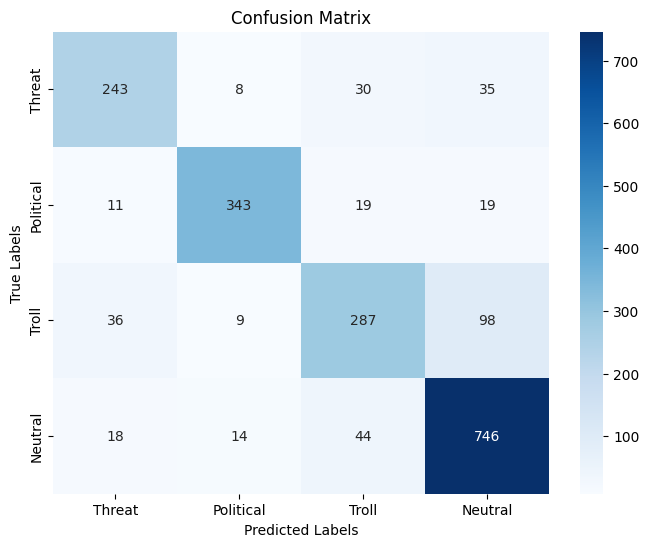

In [82]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Add regularization

In [83]:
from keras.layers import Dense
from keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(Dense(4, activation='softmax'))


In [84]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,871,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,995,236 (7.61 MB)

 Trainable params: 1,995,236 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Validation Accuracy: 0.7015, Precision: 0.6986, Recall: 0.7015, F1 Score: 0.6989
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5124 - loss: 1.3452 - val_accuracy: 0.7015 - val_loss: 0.7905
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.7964, Precision: 0.8156, Recall: 0.7964, F1 Score: 0.8014
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7818 - loss: 0.6058 - val_accuracy: 0.7964 - val_loss: 0.5843
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.7969, Precision: 0.8292, Recall: 0.7969, F1 Score: 0.8044
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9093 - loss: 0.3076 - val_accuracy: 0.7969 - val_loss: 0.5967
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.7954, Precision: 0.8192, Recall: 0.7954, F1 Score: 0.8023
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9603 - loss: 0.1672 - val_accuracy: 0.7954 - val_loss: 0.7006
Ep

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


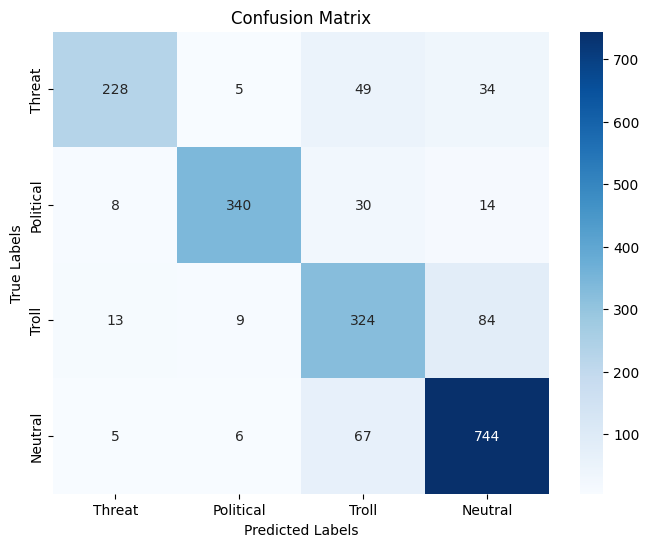

In [87]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# BILSTM-CNN

In [88]:


model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Use BiLSTM
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(Dense(4, activation='softmax'))


In [89]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Validation Accuracy: 0.726, Precision: 0.7215, Recall: 0.726, F1 Score: 0.7141
245/245 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.5249 - loss: 1.2955 - val_accuracy: 0.7260 - val_loss: 0.7559
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Validation Accuracy: 0.8071, Precision: 0.8178, Recall: 0.8071, F1 Score: 0.8073
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7979 - loss: 0.5747 - val_accuracy: 0.8071 - val_loss: 0.5859
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Validation Accuracy: 0.799, Precision: 0.8098, Recall: 0.799, F1 Score: 0.8023
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9231 - loss: 0.2738 - val_accuracy: 0.7990 - val_loss: 0.6385
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Validation Accuracy: 0.8143, Precision: 0.8196, Recall: 0.8143, F1 Score: 0.816
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9625 - loss: 0.1504 - val_accuracy: 0.8143 - val_loss: 0.6988
Epo

## Add globalmaxpooling

In [91]:

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,871,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,962,436 (7.49 MB)

 Trainable params: 1,962,436 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.8265, Precision: 0.8355, Recall: 0.8265, F1 Score: 0.8262
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5237 - loss: 1.5557 - val_accuracy: 0.8265 - val_loss: 0.5992
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.8495, Precision: 0.8514, Recall: 0.8495, F1 Score: 0.8471
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9026 - loss: 0.3938 - val_accuracy: 0.8495 - val_loss: 0.5091
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8439, Precision: 0.8466, Recall: 0.8439, F1 Score: 0.8445
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9788 - loss: 0.1587 - val_accuracy: 0.8439 - val_loss: 0.5346
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.848, Precision: 0.8509, Recall: 0.848, F1 Score: 0.8482
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9907 - loss: 0.0843 - val_accuracy: 0.8480 - val_loss: 0.5567
Epoch 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


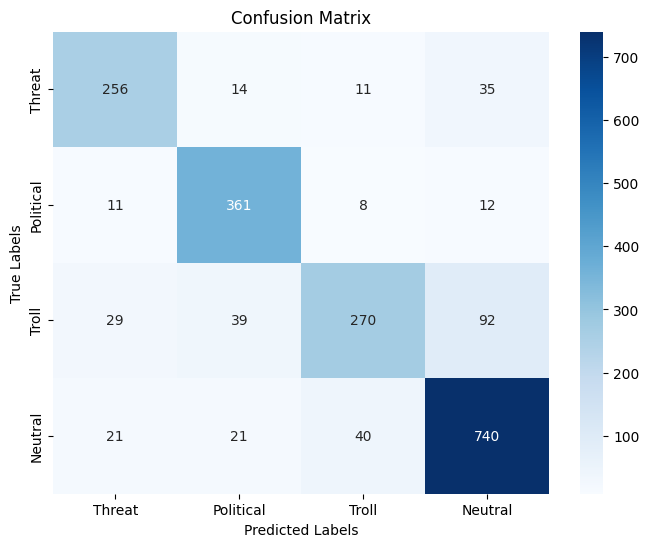

In [94]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Without FC layer

In [95]:

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │     1,871,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,954,436 (7.46 MB)

 Trainable params: 1,954,436 (7.46 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.8291, Precision: 0.8377, Recall: 0.8291, F1 Score: 0.827
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5375 - loss: 1.0713 - val_accuracy: 0.8291 - val_loss: 0.4673
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8592, Precision: 0.8608, Recall: 0.8592, F1 Score: 0.8595
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9190 - loss: 0.2594 - val_accuracy: 0.8592 - val_loss: 0.4322
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.849, Precision: 0.8488, Recall: 0.849, F1 Score: 0.8477
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9823 - loss: 0.0767 - val_accuracy: 0.8490 - val_loss: 0.4963
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8464, Precision: 0.846, Recall: 0.8464, F1 Score: 0.8459
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9901 - loss: 0.0347 - val_accuracy: 0.8464 - val_loss: 0.5463
Epoch 5

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


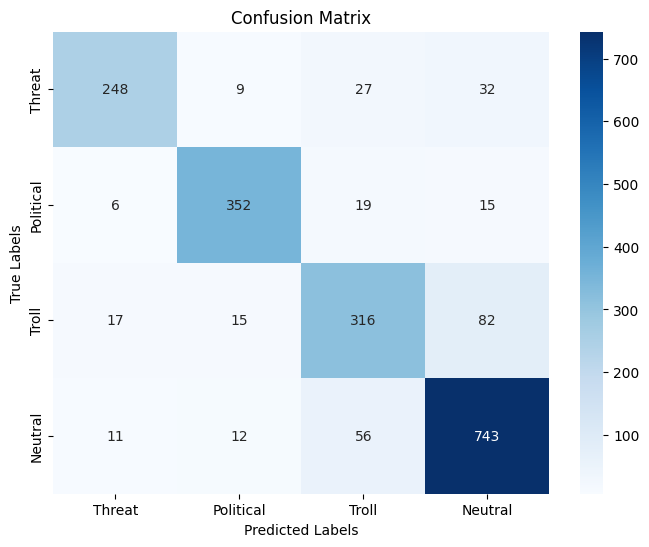

In [98]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# BILSTM-CNN from the paper

In [99]:

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128)) # Embedding layer
model.add(SpatialDropout1D(0.2))  # Spatial Dropout layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Conv1D(64, 3, activation='relu'))  # Conv1D layer
model.add(GlobalMaxPooling1D())  # Global Average Pooling layer
model.add(Dense(4, activation='softmax'))  # Dense layer


In [100]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 128)       │     1,871,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,995,588 (7.61 MB)

 Trainable params: 1,995,588 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Validation Accuracy: 0.8214, Precision: 0.8284, Recall: 0.8214, F1 Score: 0.8207
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.5356 - loss: 1.0799 - val_accuracy: 0.8214 - val_loss: 0.4725
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Validation Accuracy: 0.8408, Precision: 0.8397, Recall: 0.8408, F1 Score: 0.84
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9104 - loss: 0.2655 - val_accuracy: 0.8408 - val_loss: 0.4741
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Validation Accuracy: 0.8408, Precision: 0.8392, Recall: 0.8408, F1 Score: 0.8392
245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9735 - loss: 0.0969 - val_accuracy: 0.8408 - val_loss: 0.6015
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Validation Accuracy: 0.8398, Precision: 0.8403, Recall: 0.8398, F1 Score: 0.8399
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.9868 - loss: 0.0436 - val_accuracy: 0.8398 - val_loss: 0.645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


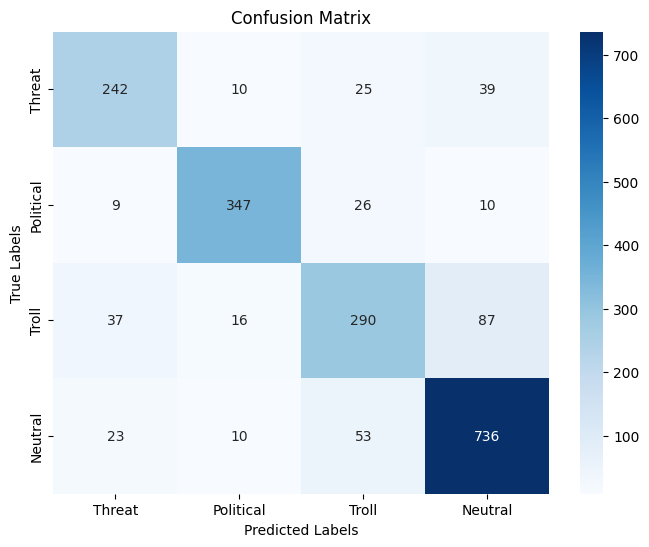

In [103]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> Best Model with 85% accuracy</center>


In [104]:
model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.826, Precision: 0.8313, Recall: 0.826, F1 Score: 0.8218
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5106 - loss: 1.1272 - val_accuracy: 0.8260 - val_loss: 0.4617
Epoch 2/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.848, Precision: 0.8489, Recall: 0.848, F1 Score: 0.8475
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9095 - loss: 0.2736 - val_accuracy: 0.8480 - val_loss: 0.4402
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8423, Precision: 0.8429, Recall: 0.8423, F1 Score: 0.8401
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9799 - loss: 0.0832 - val_accuracy: 0.8423 - val_loss: 0.5156


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


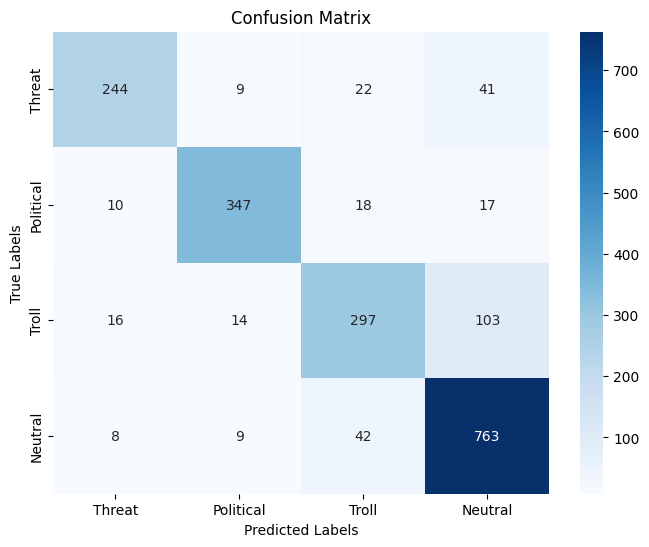

In [106]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [107]:
optimizer = Adam(learning_rate=0.001)

In [108]:

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [109]:
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Validation Accuracy: 0.8301, Precision: 0.8378, Recall: 0.8301, F1 Score: 0.8323
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5391 - loss: 1.0721 - val_accuracy: 0.8301 - val_loss: 0.4733
Epoch 2/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.8459, Precision: 0.8453, Recall: 0.8459, F1 Score: 0.8451
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9170 - loss: 0.2615 - val_accuracy: 0.8459 - val_loss: 0.4532
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8485, Precision: 0.8511, Recall: 0.8485, F1 Score: 0.849
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9841 - loss: 0.0736 - val_accuracy: 0.8485 - val_loss: 0.5252


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


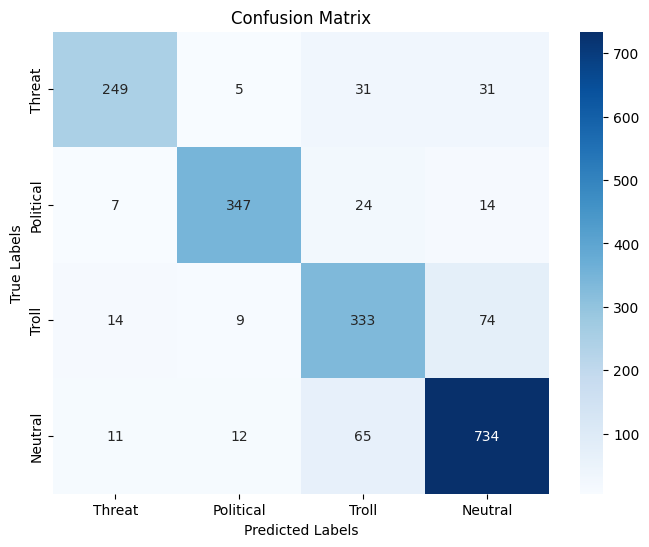

In [110]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [111]:

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 64))
model.add(SpatialDropout1D(0.3))  # Spatial Dropout layer
model.add(Bidirectional(LSTM(64, return_sequences=True))) 
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.5135 - loss: 1.1075 - val_accuracy: 0.7985 - val_loss: 0.5558
Epoch 2/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8619 - loss: 0.3765 - val_accuracy: 0.8362 - val_loss: 0.4634
Epoch 3/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9544 - loss: 0.1536 - val_accuracy: 0.8347 - val_loss: 0.5203


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


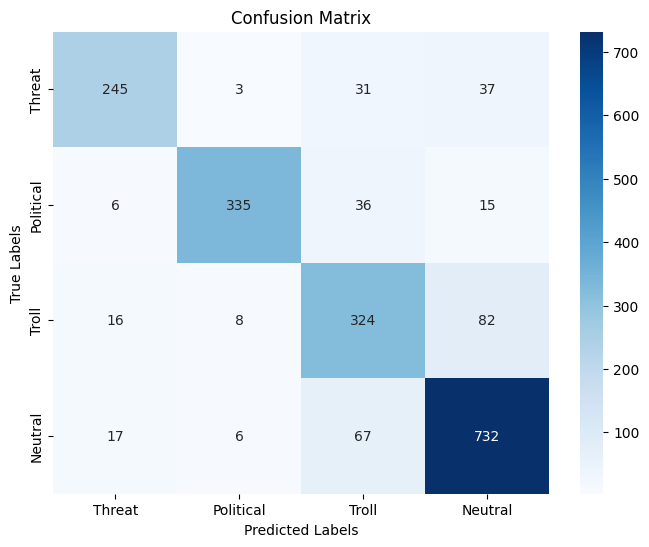

In [113]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [114]:

model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 64))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy: 0.8163, Precision: 0.8222, Recall: 0.8163, F1 Score: 0.816
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4704 - loss: 1.1815 - val_accuracy: 0.8163 - val_loss: 0.5261
Epoch 2/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation Accuracy: 0.85, Precision: 0.8506, Recall: 0.85, F1 Score: 0.848
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8946 - loss: 0.3480 - val_accuracy: 0.8500 - val_loss: 0.4485
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation Accuracy: 0.8485, Precision: 0.8479, Recall: 0.8485, F1 Score: 0.8475
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9689 - loss: 0.1260 - val_accuracy: 0.8485 - val_loss: 0.4718


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


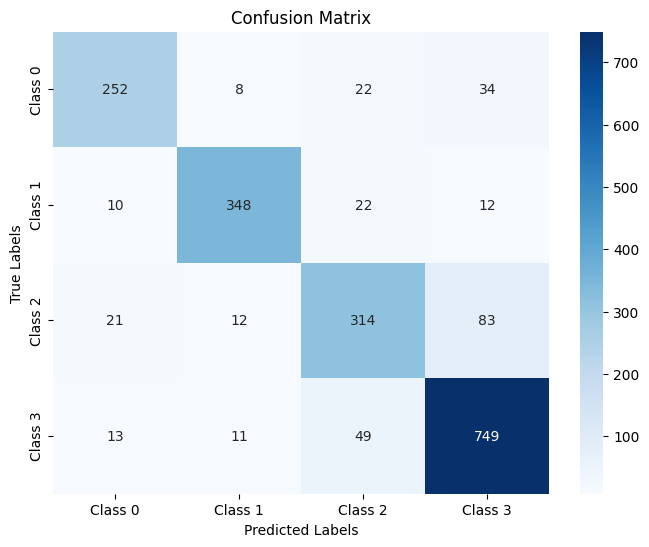

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [117]:
model = Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:

history = model.fit(X_train, y_train, batch_size=32, epochs=4, validation_data=(X_test, y_test), callbacks=[metrics_callback])

Epoch 1/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Validation Accuracy: 0.8255, Precision: 0.8406, Recall: 0.8255, F1 Score: 0.8285
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5469 - loss: 1.0634 - val_accuracy: 0.8255 - val_loss: 0.4888
Epoch 2/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.8515, Precision: 0.8528, Recall: 0.8515, F1 Score: 0.8506
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9182 - loss: 0.2604 - val_accuracy: 0.8515 - val_loss: 0.4436
Epoch 3/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8434, Precision: 0.8433, Recall: 0.8434, F1 Score: 0.8429
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9821 - loss: 0.0793 - val_accuracy: 0.8434 - val_loss: 0.5173
Epoch 4/4
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.8454, Precision: 0.8457, Recall: 0.8454, F1 Score: 0.8454
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9926 - loss: 0.0291 - val_accuracy: 0.8454 - val_loss: 0.5577


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


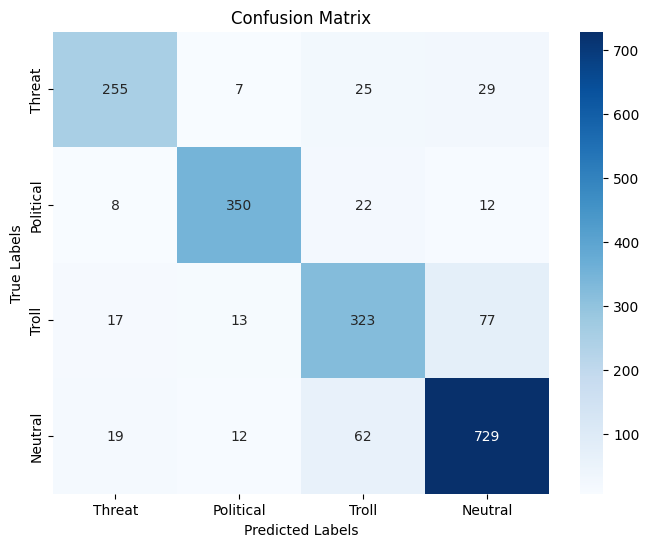

In [119]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [120]:
model.save('best_model.h5')

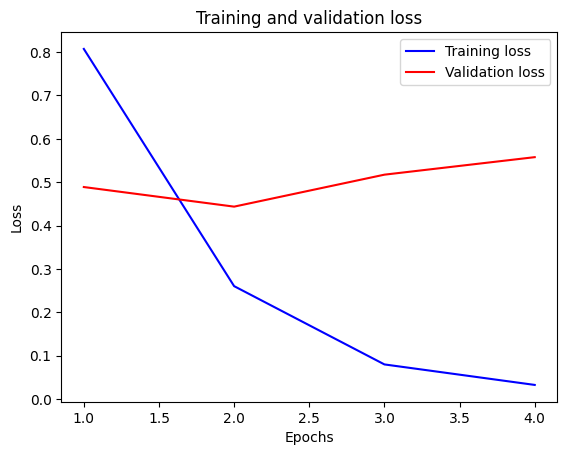

In [121]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the loss function
plt.plot(epochs, train_loss, 'b-', label='Training loss')  # Blue curve for training loss
plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Red curve for validation loss
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


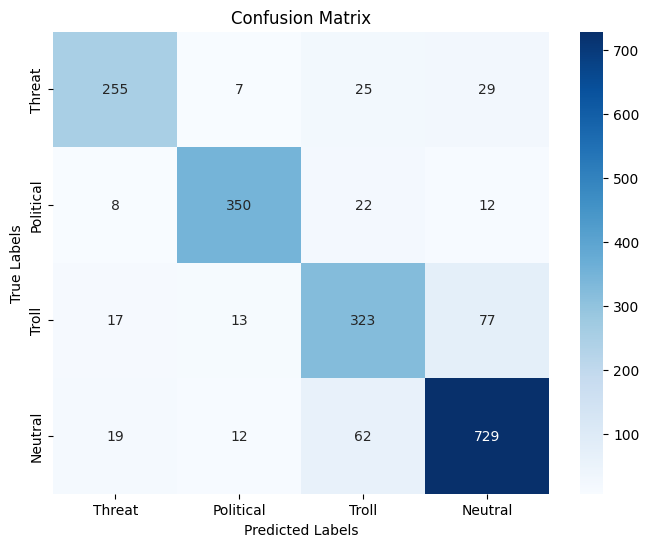

In [122]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Threat', 'Political', 'Troll', 'Neutral'], yticklabels=['Threat', 'Political', 'Troll', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
